## installazione delle librerie necessarie per lo svilluppo di una analisi dei dati :

In [3]:
import pandas as pd  # per i dataframe  
import numpy as np  # per i calcoli numerici
import matplotlib.pyplot as plt # per i grafici
import seaborn as sns # per i grafici
import os   # per la gestione dei file
import sys # per la gestione dei file
import argparse  # per la gestione dei parametri da linea di comando
import re # per le espressioni regolari
import plotly.express as px # per i grafici
import plotly.graph_objects as go # per i grafici
import plotly.figure_factory as ff # per i grafici
import plotly.offline as py # per i grafici
import glob # per la gestione dei file
from math import pi
import geopandas as gpd # per i dati geografici
import matplotlib.pyplot as plt # per i grafici
from geopy.geocoders import Nominatim # per la geocodifica
from geopy.extra.rate_limiter import RateLimiter
import folium as folium # per i grafici geografici
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [4]:
# Imposta lo stile dei grafici
sns.set(style="whitegrid", palette="pastel", color_codes=True)
# Utilizzo di una palette di colori personalizzata
custom_palette = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6", "#f1c40f"]
sns.set_palette(custom_palette)

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [5]:
# importo i dati
dataClubs = pd.read_csv("./AssignmentData/clubs.csv", sep=",", decimal=".")
dataGames = pd.read_csv("./AssignmentData/games.csv", sep=",", decimal=".")
dataPlayers = pd.read_csv("./AssignmentData/players.csv", sep=",", decimal=".")
dataCompetitions = pd.read_csv("./AssignmentData/competitions.csv", sep=",", decimal=".")
dataGamesLineups = pd.read_csv("./AssignmentData/game_lineups.csv", sep=",", decimal=".")
dataGamesEvents = pd.read_csv("./AssignmentData/game_events.csv", sep=",", decimal=".")
dataAppearance = pd.read_csv("./AssignmentData/appearances.csv", sep=",", decimal=".")
dataPlayersValues = pd.read_csv("./AssignmentData/player_valuations.csv", sep=",", decimal=".")



## Analizziamo i dati a disposizione per progettare  una analisi e visualizzazioni che possano rendere più visibile le dinamiche delle squadre, il comportamento dei giocatori e le strategie adottate durante le partite. Suddivideremo l'analisi in diverse sezioni basate sui dataset forniti.

### Distribuzione dei club nel mondo

/var/folders/9x/57__ff_j1wscnvbjdyy9gsrw0000gp/T/ipykernel_46818/493848029.py:11: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



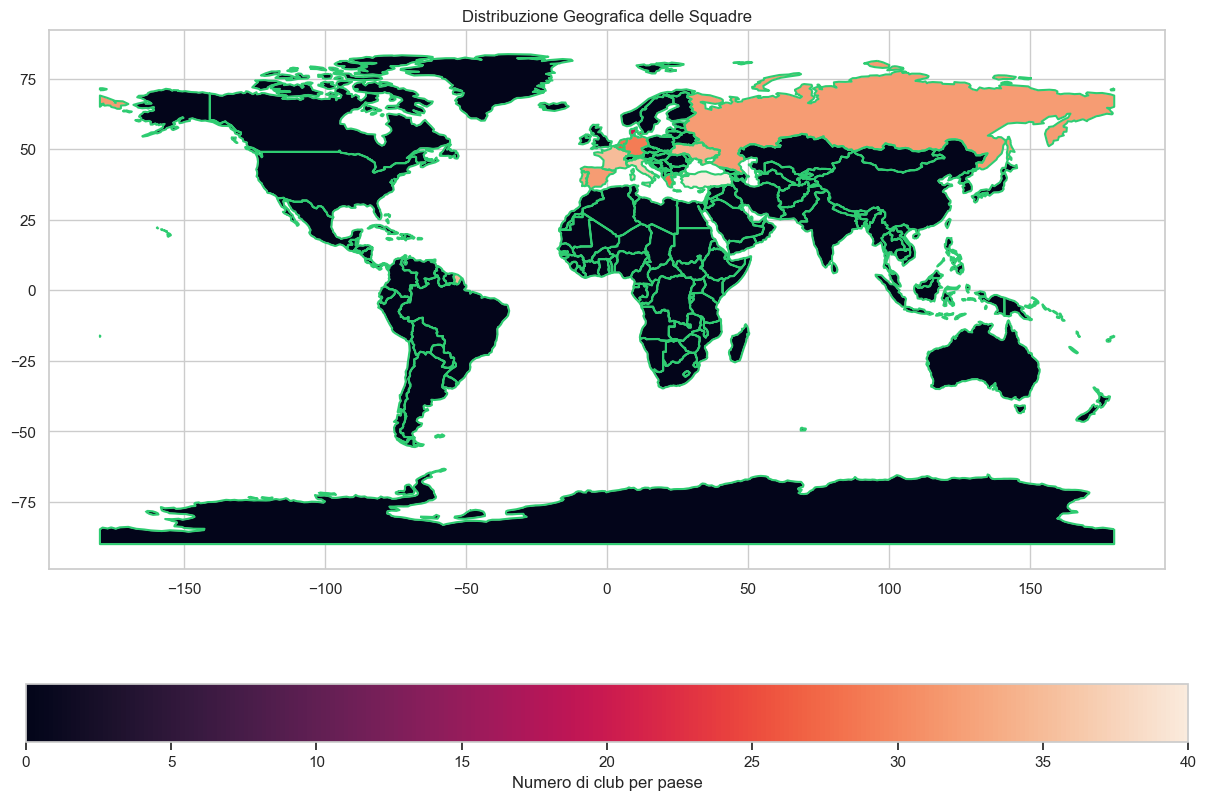

In [6]:

# Supponendo di avere i dataframe caricati come dataClubs e dataCompetitions

# Uniamo i dataframe sui rispettivi ID delle competizioni domestiche
merged_data = pd.merge(dataClubs, dataCompetitions, left_on='domestic_competition_id', right_on='competition_id', how='inner')

# Contiamo il numero di club per paese
country_club_counts = merged_data['country_name'].value_counts().reset_index()
country_club_counts.columns = ['country', 'number_of_clubs']

# Carichiamo un geodataframe con i confini dei paesi
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Uniamo i dati dei club con il geodataframe
world_clubs = world.merge(country_club_counts, how="left", left_on="name", right_on="country")

# Impostiamo i valori NaN a 0
world_clubs['number_of_clubs'] = world_clubs['number_of_clubs'].fillna(0)

# Creiamo la mappa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_clubs.boundary.plot(ax=ax)
world_clubs.plot(column='number_of_clubs', ax=ax, legend=True,
                 legend_kwds={'label': "Numero di club per paese",
                              'orientation': "horizontal"})
plt.title('Distribuzione Geografica delle Squadre')
plt.show()


# 1. Analisi della qualità di gioco dei Club

Creazione di una visualizzazione che mostra i valori dei club in termini di goal, assist, cartellini gialli e rossi.
Attraverso una serie di step andremo a valutare i club che hanno ottenuto una maggior crescita a livello di qualità di gioco nel tempo 

### a. generazione di una tabella che contiene, assegnati ai club, i valori ottenuti da Appearence dei giocatori nelle varie partite

In [7]:
# Unire i dati dei giocatori con i dati delle valutazioni.
# Raggruppare i dati per player_id e sommare i valori
stats_sum = dataAppearance.groupby('player_id')[['yellow_cards', 'red_cards', 'goals', 'assists']].sum().reset_index()

# Unire le somme con gli id dei club
player_stats = pd.merge(stats_sum, dataAppearance[['player_id', 'player_club_id', 'player_current_club_id']].drop_duplicates(), on='player_id', how='left')

club_max_red = player_stats.groupby('player_club_id')['red_cards'].max().reset_index()
club_max_goals = player_stats.groupby('player_club_id')[ 'goals'].max().reset_index()
club_max_assists = player_stats.groupby('player_club_id')['assists'].max().reset_index()
club_max_yellow = player_stats.groupby('player_club_id')['yellow_cards'].max().reset_index()
# Unire i risultati in una tabella unica
result = pd.merge(club_max_yellow, club_max_red, on='player_club_id', how='inner')
result = pd.merge(result, club_max_assists, on='player_club_id', how='inner')
result = pd.merge(result, club_max_goals, on='player_club_id', how='inner')

# Rinominare le colonne per chiarezza
result.columns = ['player_club_id', 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals']

# Visualizzare i club in ordine di massimo numero di cartellini gialli, rossi, assist e goal
result.sort_values(by=['max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals'], ascending=False, inplace=True)


### b. Generazione di una tabella che ordina i club in base ai propri giocatori che hanno ottenuto il maggior numero di cartellini e fatto il maggior numero di assist e goal

In [8]:
club_max_red = player_stats.groupby('player_club_id')['red_cards'].max().reset_index()
club_max_goals = player_stats.groupby('player_club_id')[ 'goals'].max().reset_index()
club_max_assists = player_stats.groupby('player_club_id')['assists'].max().reset_index()
club_max_yellow = player_stats.groupby('player_club_id')['yellow_cards'].max().reset_index()

# Unire i risultati in una tabella unica
result = pd.merge(club_max_yellow, club_max_red, on='player_club_id', how='inner')
result = pd.merge(result, club_max_assists, on='player_club_id', how='inner')
result = pd.merge(result, club_max_goals, on='player_club_id', how='inner')

# Rinominare le colonne per chiarezza
result.columns = ['player_club_id', 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals']

# Visualizzare i club in ordine di massimo numero di cartellini gialli, rossi, assist e goal
result.sort_values(by=['max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals'], ascending=False, inplace=True)
result = pd.merge(result, dataClubs[['club_id', 'name']], left_on='player_club_id', right_on='club_id', how='left')


# Rimuovere le righe dove 'player_club_id' è NaN
result = result.dropna(subset=['club_id'])

# Rimuovere le righe dove tutti i valori di 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals' sono 0
result = result[~((result['max_yellow_cards'] == 0) & (result['max_red_cards'] == 0) & (result['max_assists'] == 0) & (result['max_goals'] == 0))]

# Visualizzare i risultati
result

,player_club_id,max_yellow_cards,max_red_cards,max_assists,max_goals,club_id,name
0,583,138,6,219,443,583.0,Paris Saint-Germain Football Club
1,418,138,6,161,432,418.0,Real Madrid Club de Fútbol
2,368,138,6,91,250,368.0,Sevilla Fútbol Club S.A.D.
3,131,136,3,219,449,131.0,Futbol Club Barcelona
4,13,130,4,139,283,13.0,Club Atlético de Madrid S.A.D.
...,...,...,...,...,...,...,...
557,724,23,2,20,51,724.0,Football Club Volendam
558,3385,23,1,16,11,3385.0,Panserraikos Serres
568,54189,21,3,43,30,54189.0,Racing White Daring Molenbeek
612,39097,17,1,2,4,39097.0,FK Obolon Kyiv


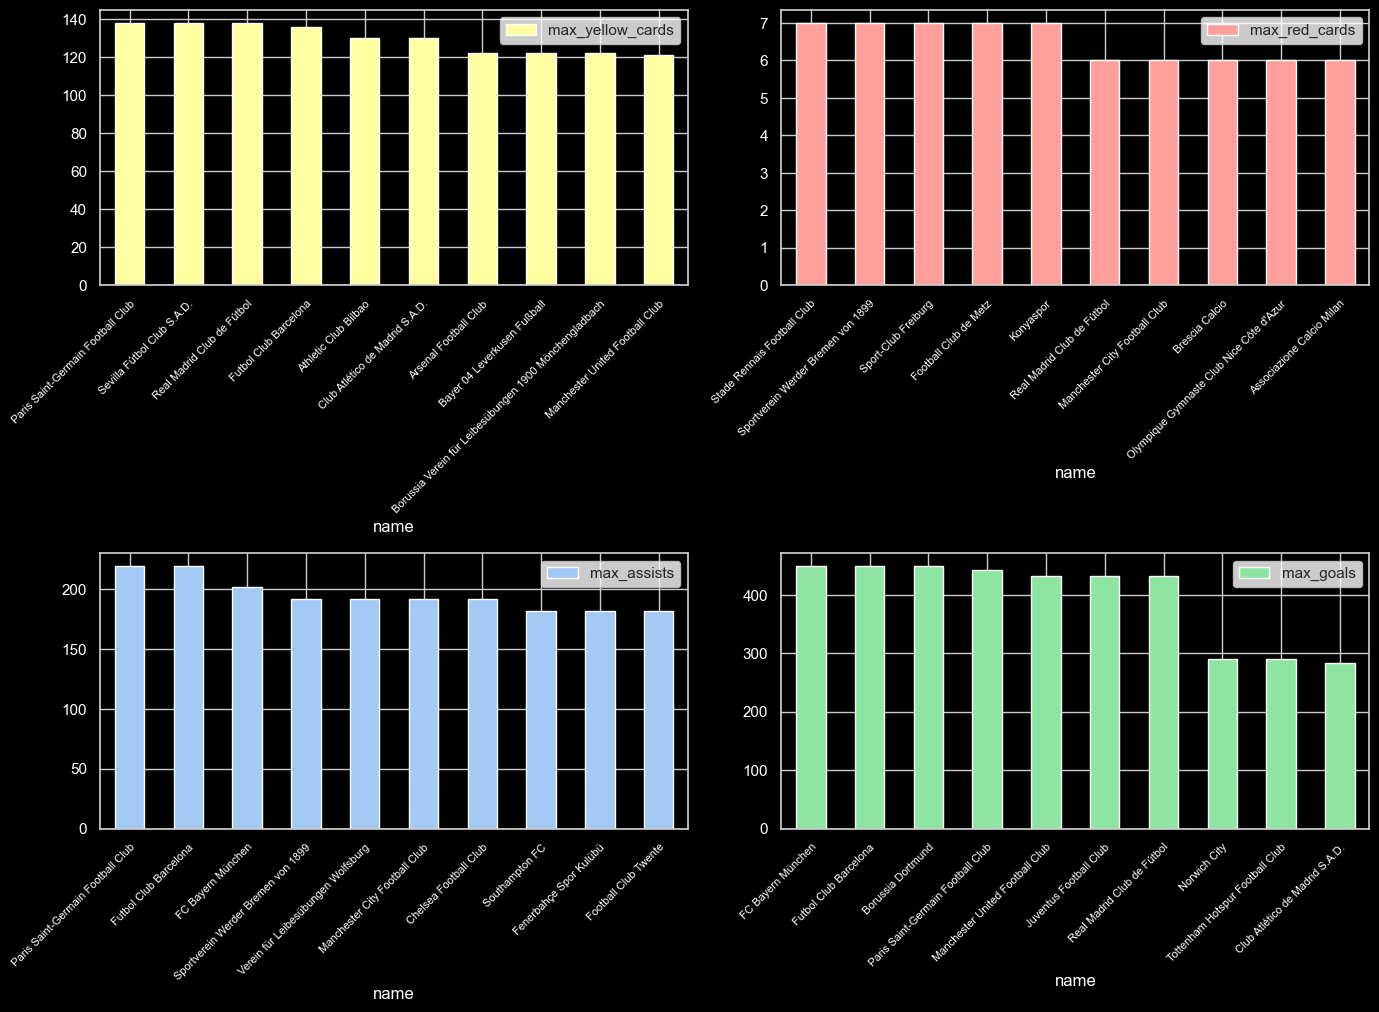

<Figure size 640x480 with 0 Axes>

In [9]:
# Grafici a barre
# Grafici a barre
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='black')  # Cambia lo sfondo del figure

# Definire i colori del testo per alta visibilità sullo sfondo nero
text_color = 'white'

# Configurare ogni subplot
for ax, metric, color in zip(axes.flatten(),
                            ['max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals'],
                            ['y', 'r', 'b', 'g']):
    
    # Ordinare e creare il grafico a barre
    result.sort_values(metric, ascending=False).head(10).plot(
        x='name', y=metric, kind='bar', ax=ax, color=color
    )
    
    # Cambiare lo sfondo del subplot
    ax.set_facecolor('black')
    
    # Impostare il colore del testo e delle spine per alta visibilità
    ax.tick_params(colors=text_color, which='both')  # Cambia il colore dei tick
    ax.xaxis.label.set_color(text_color)  # Cambia il colore della label dell'asse x
    ax.yaxis.label.set_color(text_color)  # Cambia il colore della label dell'asse y
    ax.title.set_color(text_color)  # Cambia il colore del titolo
    
    # Imposta i nomi sull'asse x per andare a capo e riduci la dimensione del font
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8, wrap=True)

plt.tight_layout()
plt.show()
result.sort_values('max_yellow_cards', ascending=False).head(10).plot(x='name', y='max_yellow_cards', kind='bar', ax=axes[0, 0], color='y')
result.sort_values('max_red_cards', ascending=False).head(10).plot(x='name', y='max_red_cards', kind='bar', ax=axes[0, 1], color='r')
result.sort_values('max_assists', ascending=False).head(10).plot(x='name', y='max_assists', kind='bar', ax=axes[1, 0], color='b')
result.sort_values('max_goals', ascending=False).head(10).plot(x='name', y='max_goals', kind='bar', ax=axes[1, 1], color='g')
plt.tight_layout()
plt.show()

### c. ottengo il club che ha ottenuto il maggior di cartellini rossi, gialli , assist e goal dai loro giocatori ma suddivisi per anno

In [10]:
# Assumiamo che dataAppearance sia il tuo DataFrame
dataAppearance['year'] = pd.to_datetime(dataAppearance['date']).dt.year

# Raggruppare i dati per player_club_id e anno
grouped_data = dataAppearance.groupby(['player_club_id', 'year'])

# Calcolare i valori massimi per ogni club e anno
club_year_max_red = grouped_data['red_cards'].max().reset_index()
club_year_max_goals = grouped_data['goals'].max().reset_index()
club_year_max_assists = grouped_data['assists'].max().reset_index()
club_year_max_yellow = grouped_data['yellow_cards'].max().reset_index()

# Unire i risultati in una tabella unica
result = pd.merge(club_year_max_yellow, club_year_max_red, on=['player_club_id', 'year'], how='inner')
result = pd.merge(result, club_year_max_assists, on=['player_club_id', 'year'], how='inner')
result = pd.merge(result, club_year_max_goals, on=['player_club_id', 'year'], how='inner')

# Rinominare le colonne per chiarezza
result.columns = ['player_club_id', 'year', 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals']

# Visualizzare i club in ordine di massimo numero di cartellini gialli, rossi, assist e goal per anno
result.sort_values(by=['year', 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals'], ascending=[True, False, False, False, False], inplace=True)
result = pd.merge(result, dataClubs[['club_id', 'name']], left_on='player_club_id', right_on='club_id', how='left')


# Rimuovere le righe dove 'player_club_id' è NaN
result = result.dropna(subset=['club_id'])

# Rimuovere le righe dove tutti i valori di 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals' sono 0
result = result[~((result['max_yellow_cards'] == 0) & (result['max_red_cards'] == 0) & (result['max_assists'] == 0) & (result['max_goals'] == 0))]

# Visualizzare il risultato finale
result

,player_club_id,year,max_yellow_cards,max_red_cards,max_assists,max_goals,club_id,name
0,499,2012,2,1,4,3,499.0,Stichting Betaald Voetbal Vitesse Arnhem
1,583,2012,2,1,4,3,583.0,Paris Saint-Germain Football Club
2,2282,2012,2,1,4,3,2282.0,Club Brugge Koninklijke Voetbalvereniging
3,42,2012,2,1,4,2,42.0,Hannover 96
4,2700,2012,2,1,4,2,2700.0,Anzhi Makhachkala ( -2022)
...,...,...,...,...,...,...,...,...
5316,2451,2023,0,0,1,1,2451.0,Inverness Caledonian Thistle FC
5321,289,2023,0,0,1,0,289.0,Sunderland AFC
5324,132,2023,0,0,0,1,132.0,NAC Breda
5327,603,2023,0,0,0,1,603.0,Cardiff City


### d. Questo grafico evidenzia le squadre che negli anni hanno fatto la maggior crescita a livello di qualità di gioco, quindi che hanno ottenuto una diminuizione del numero di falli commessi e ha aumentato il numero di goal e assist effettuati.
Nei grafici è evidente come il numero di falli decrementa, negli anni la maggior parte dei club ha ottenuto un gran numero di falli, facendo intuire la comparsa di alcune problematiche interne all'associazione. mentre nel corso degli anni questo numero è diminuito e ha anche portato ad una crescita maggiore a livello di performace di goal e assist.

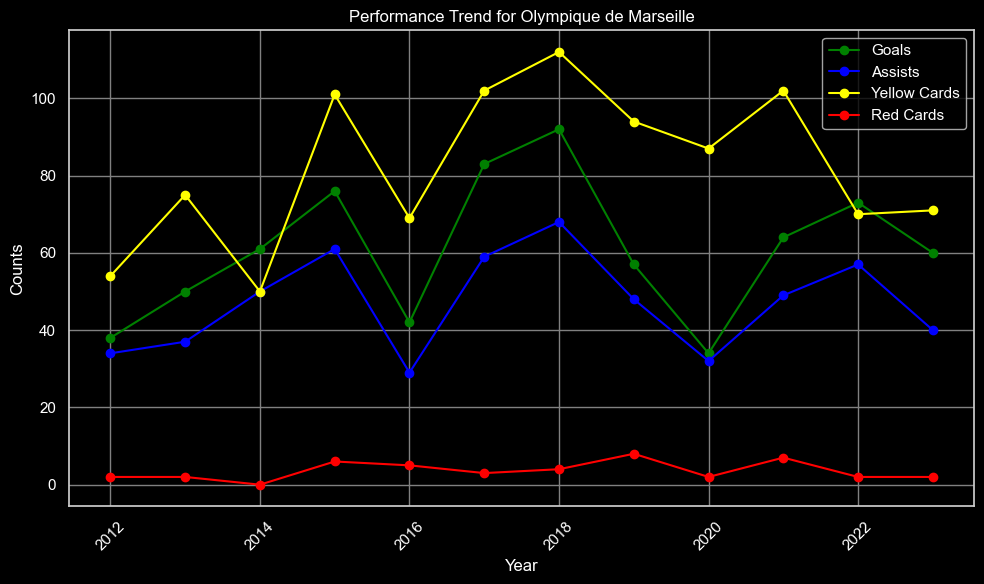

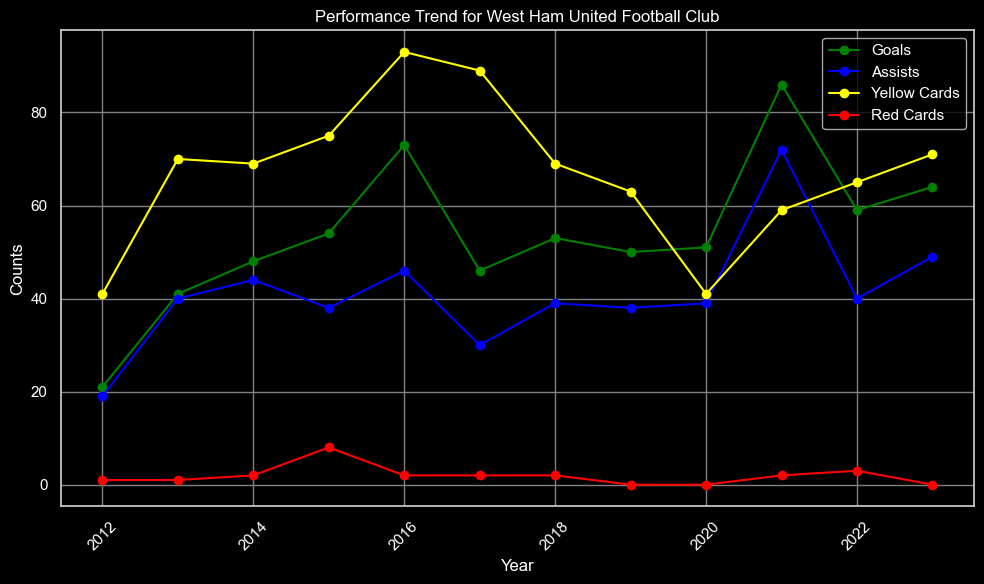

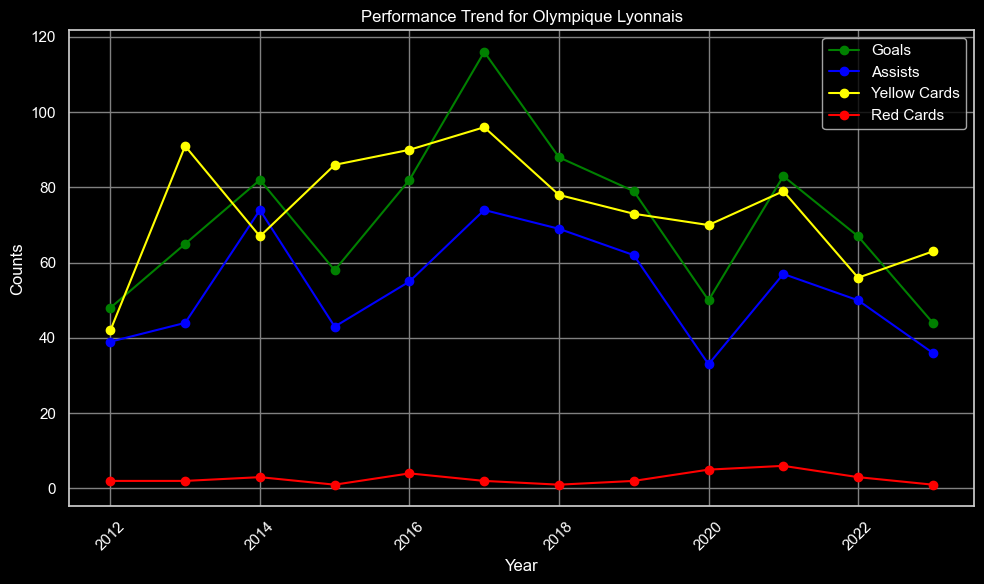

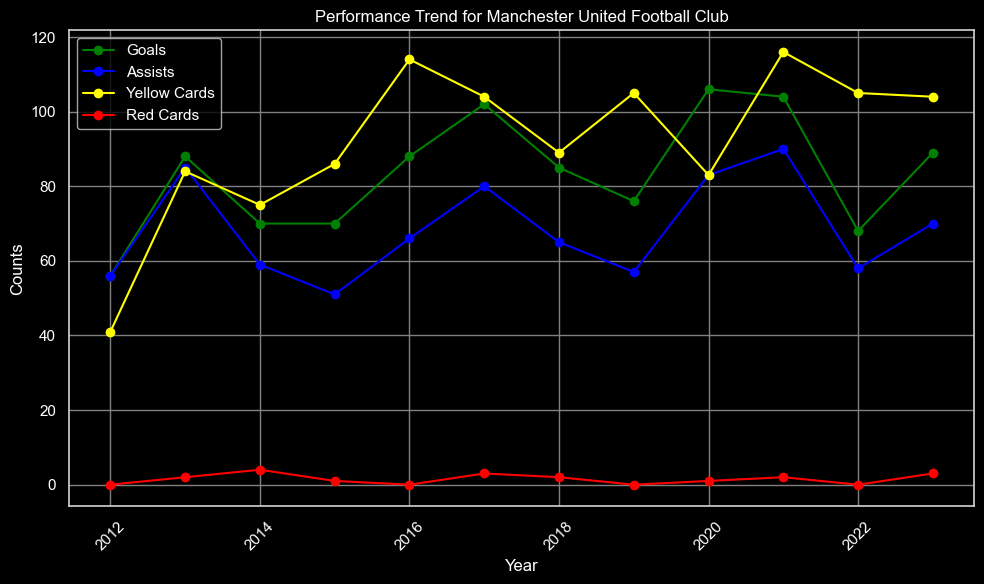

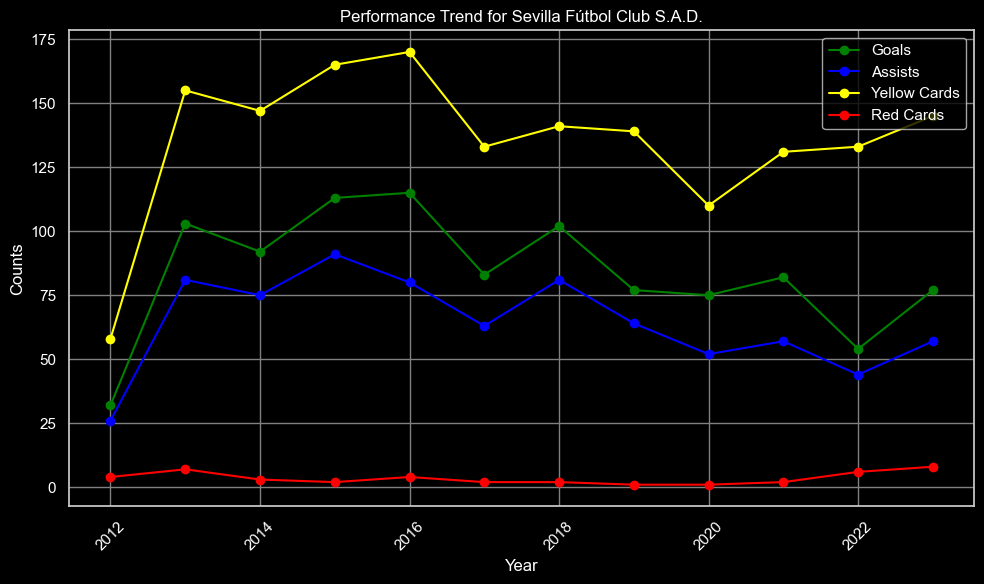

In [11]:
# Assumiamo che 'result' sia il tuo DataFrame già pulito e pronto
# Calcoliamo la somma anziché il massimo
club_year_sum = grouped_data[['yellow_cards', 'red_cards', 'goals', 'assists']].sum().reset_index()
club_year_sum = pd.merge(club_year_sum, dataClubs[['club_id', 'name']], left_on='player_club_id', right_on='club_id', how='left')

# Rimuovere le righe con valori NaN o 0 per tutte le metriche
club_year_sum = club_year_sum.dropna(subset=['club_id'])
club_year_sum = club_year_sum[~((club_year_sum['yellow_cards'] == 0) & (club_year_sum['red_cards'] == 0) & (club_year_sum['assists'] == 0) & (club_year_sum['goals'] == 0))]

# Selezionare un sottoinsieme di club per la visualizzazione (per semplicità)
# Impostazioni per lo sfondo nero e il testo bianco
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'

# Selezionare un sottoinsieme di club per la visualizzazione (per semplicità)
top_clubs = club_year_sum['name'].value_counts().index[:5]
club_year_sum = club_year_sum[club_year_sum['name'].isin(top_clubs)]

# Creare grafici a linee per ciascun club
for club in top_clubs:
    club_data = club_year_sum[club_year_sum['name'] == club].sort_values('year')
    plt.figure(figsize=(10, 6))
    
    # Cambia il colore dello sfondo per il singolo grafico
    plt.gca().set_facecolor('black')
    
    plt.plot(club_data['year'], club_data['goals'], label='Goals', color='green', marker='o')
    plt.plot(club_data['year'], club_data['assists'], label='Assists', color='blue', marker='o')
    plt.plot(club_data['year'], club_data['yellow_cards'], label='Yellow Cards', color='yellow', marker='o')
    plt.plot(club_data['year'], club_data['red_cards'], label='Red Cards', color='red', marker='o')
    
    plt.title(f'Performance Trend for {club}', color='white')
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)  # Ruota le etichette dell'asse x
    plt.legend()
    plt.grid(True, color='gray')  # Griglia con colore per alta visibilità
    plt.tight_layout()
    plt.show()

# 2. Analisi delle performance dei club 
valutazione delle performance dei club complessiva dei games vinti, pareggiati e persi, viene e stilata una classifica in cui viene valutato il club che complessivamente ha performato nel miglior modo, quindi con il maggior numero di partite vinte e il minor numero di partite perse o pareggiate 

In [12]:
# Aggiornare le condizioni per utilizzare le colonne corrette
# Merge quando il club è la squadra di casa
home_games = pd.merge(dataClubs, dataGames, left_on='club_id', right_on='home_club_id', how='left')

# Merge quando il club è la squadra ospite
away_games = pd.merge(dataClubs, dataGames, left_on='club_id', right_on='away_club_id', how='left')

# Concatenare i risultati
club_games_details = pd.concat([home_games, away_games], ignore_index=True)

# Calcolare vittorie, pareggi e sconfitte per ogni club
# Assumiamo che club_id_home sia la squadra di casa e club_id_away quella ospite

# Aggiungere colonne per vittorie, pareggi e sconfitte
club_games_details['win'] = 0
club_games_details['draw'] = 0
club_games_details['loss'] = 0

club_games_details.loc[(club_games_details['club_id'] == club_games_details['home_club_id']) & 
                       (club_games_details['home_club_goals'] > club_games_details['away_club_goals']), 'win'] = 1
club_games_details.loc[(club_games_details['club_id'] == club_games_details['away_club_id']) & 
                       (club_games_details['away_club_goals'] > club_games_details['home_club_goals']), 'win'] = 1
club_games_details.loc[(club_games_details['home_club_goals'] == club_games_details['away_club_goals']), 'draw'] = 1
club_games_details.loc[(club_games_details['club_id'] == club_games_details['home_club_id']) & 
                       (club_games_details['home_club_goals'] < club_games_details['away_club_goals']), 'loss'] = 1
club_games_details.loc[(club_games_details['club_id'] == club_games_details['away_club_id']) & 
                       (club_games_details['away_club_goals'] < club_games_details['home_club_goals']), 'loss'] = 1

# Ricreare la tabella riassuntiva per i club
club_performance = club_games_details.groupby('club_id').agg(
    wins=pd.NamedAgg(column='win', aggfunc='sum'),
    draws=pd.NamedAgg(column='draw', aggfunc='sum'),
    losses=pd.NamedAgg(column='loss', aggfunc='sum')
).reset_index()

# Unire con i nomi dei club
club_performance = club_performance.merge(dataClubs[['club_id', 'name']], on='club_id', how='left')

# Ordinare i club per vittorie, poi pareggi, e infine minor numero di sconfitte
club_performance_sorted = club_performance.sort_values(by=['wins', 'draws', 'losses'], ascending=[False, False, True])

club_performance_sorted
  # Visualizzare i primi risultati per confermare


,club_id,wins,draws,losses,name
15,27,443,72,70,FC Bayern München
45,131,435,108,92,Futbol Club Barcelona
106,418,433,104,100,Real Madrid Club de Fútbol
75,281,414,90,107,Manchester City Football Club
119,506,402,101,101,Juventus Football Club
...,...,...,...,...,...
418,54189,4,5,6,Racing White Daring Molenbeek
269,2431,4,3,10,Club Football Estrela da Amadora
152,738,3,7,3,Le Havre Athletic Club
308,3209,3,4,6,Pendikspor


# a. Percentuale di Vittorie, Pareggi e Sconfitte per Club
Analizzare la percentuale di vittorie, pareggi e sconfitte rispetto al totale delle partite giocate per ciascun club.

Codice per il Calcolo delle Percentuali:

In [13]:
club_performance_sorted['total_games'] = club_performance_sorted['wins'] + club_performance_sorted['draws'] + club_performance_sorted['losses']
club_performance_sorted['win_percentage'] = club_performance_sorted['wins'] / club_performance_sorted['total_games'] * 100
club_performance_sorted['draw_percentage'] = club_performance_sorted['draws'] / club_performance_sorted['total_games'] * 100
club_performance_sorted['loss_percentage'] = club_performance_sorted['losses'] / club_performance_sorted['total_games'] * 100


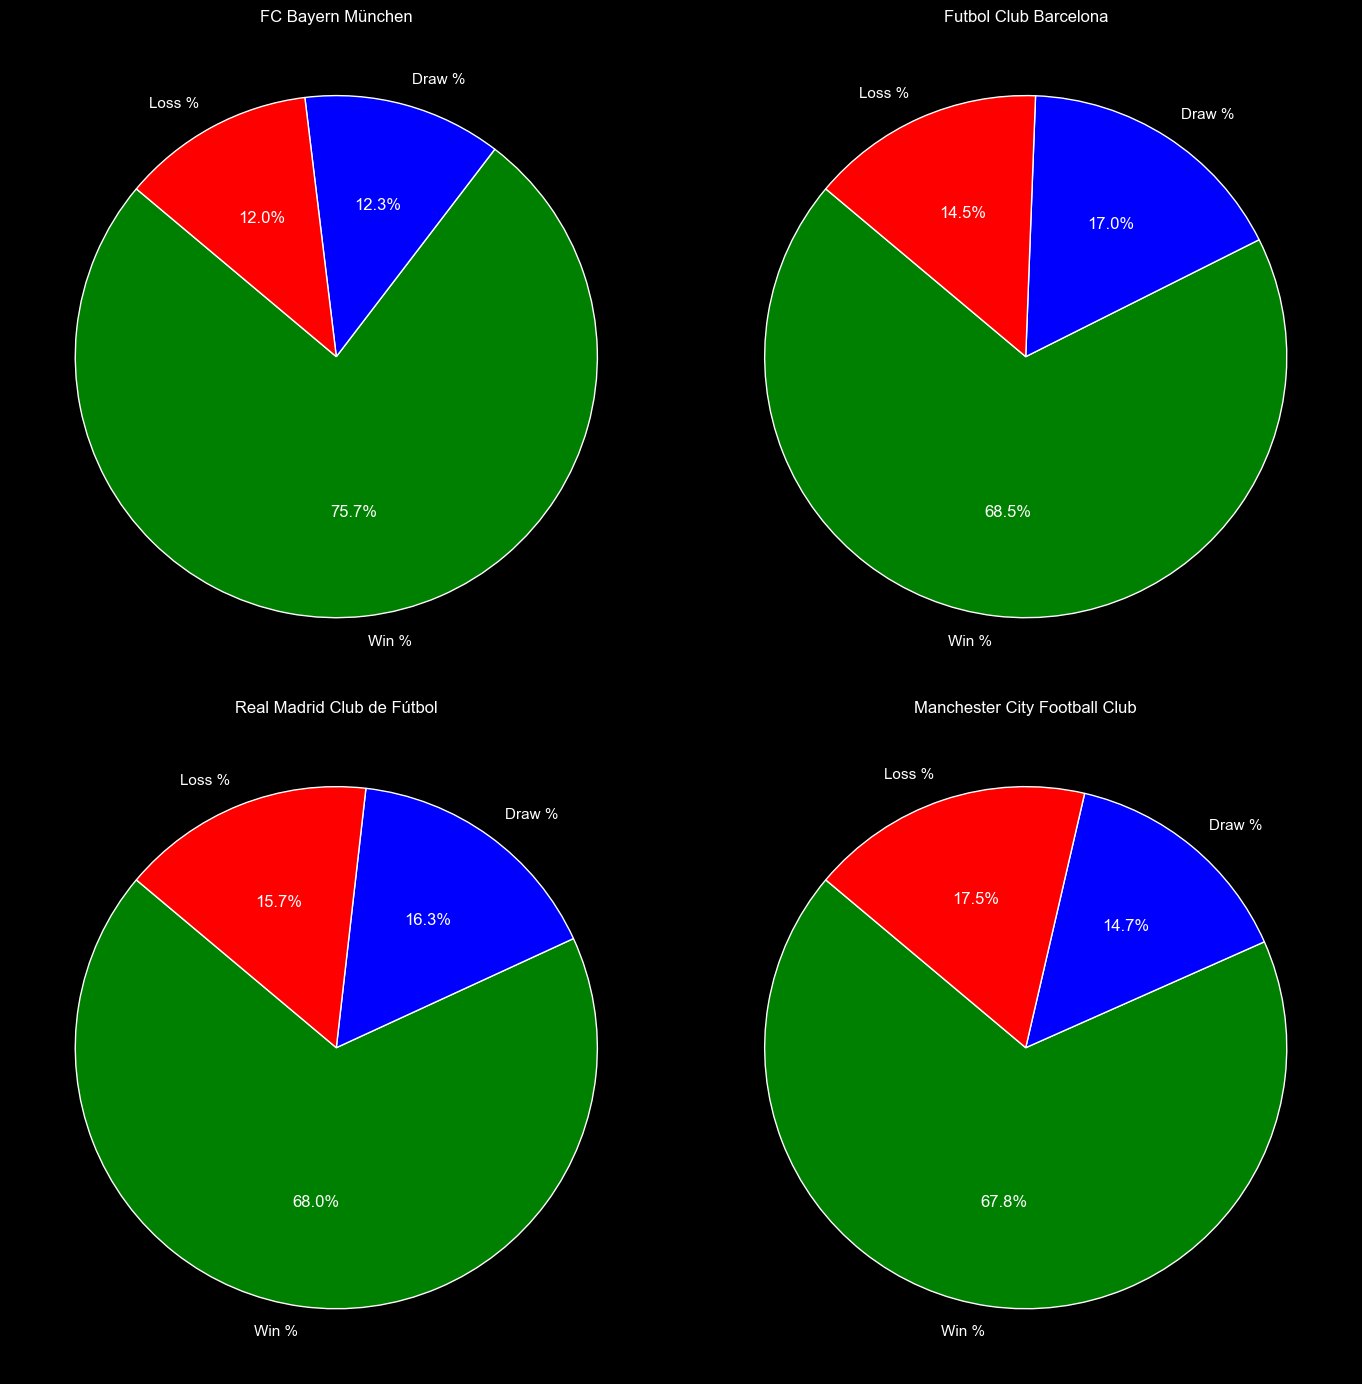

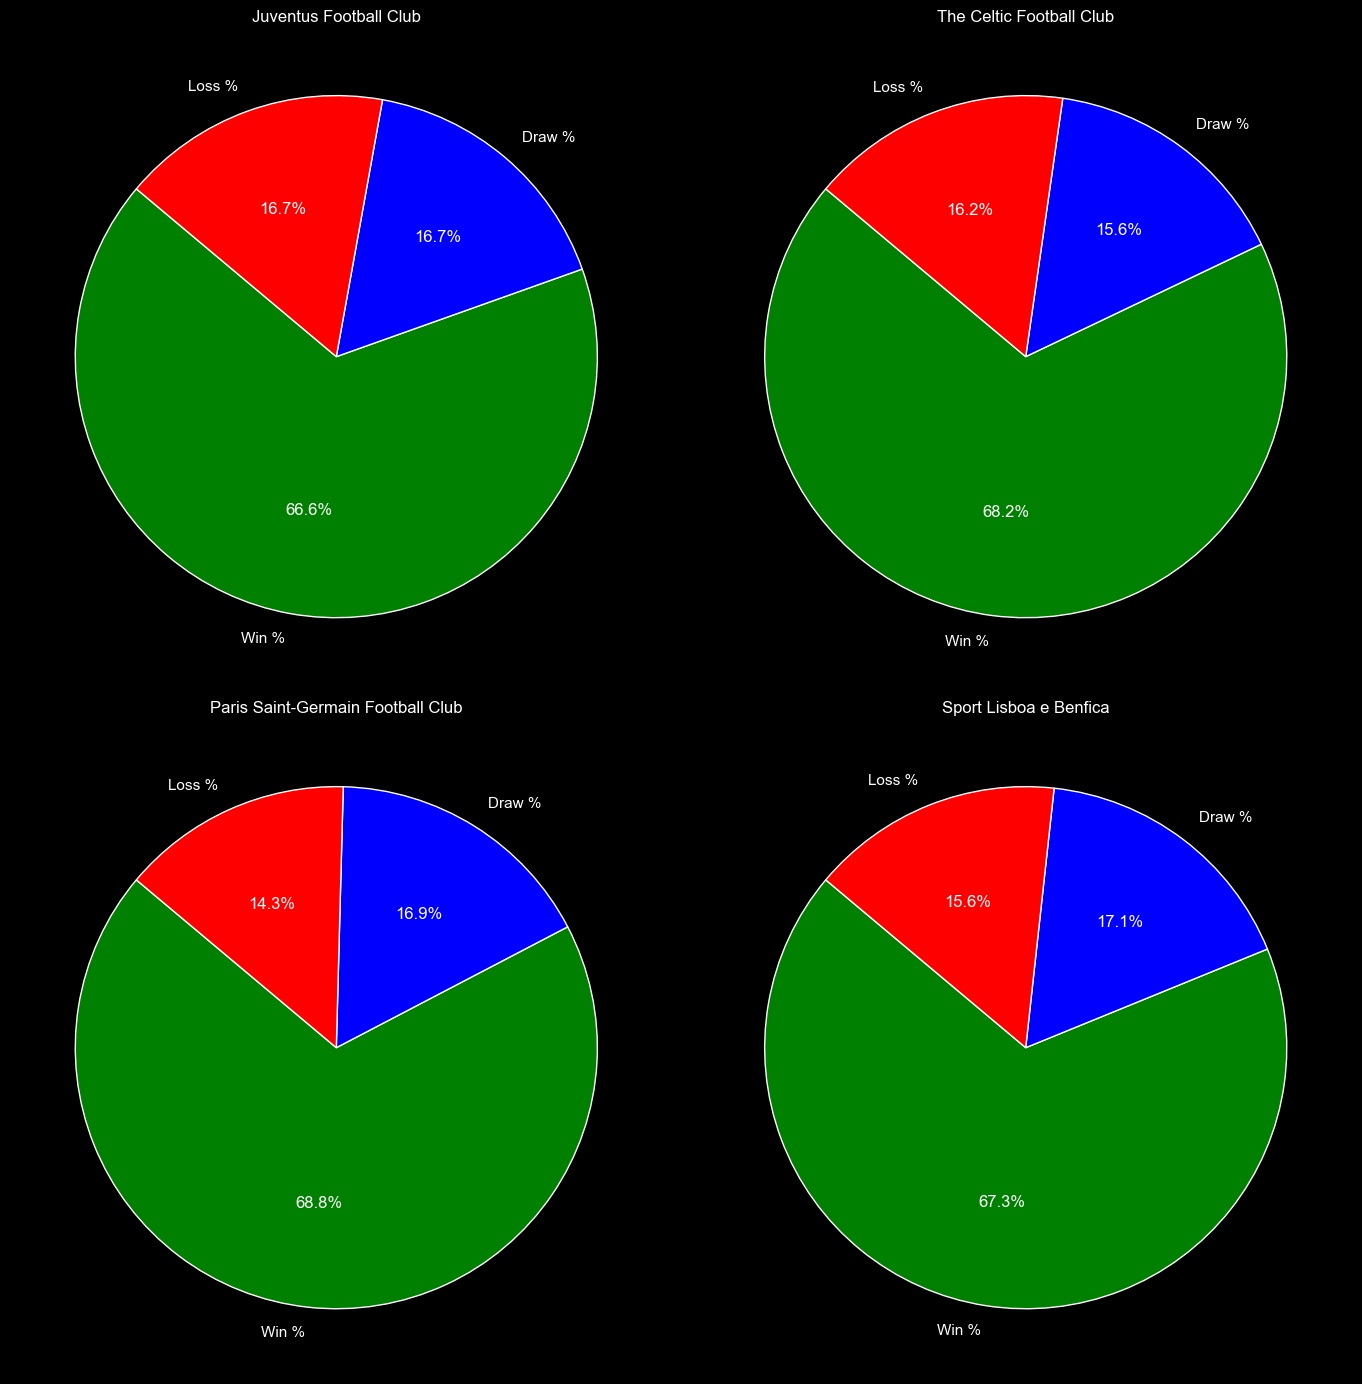

In [14]:

# Selezionare le prime 8 squadre
top_clubs = club_performance_sorted.head(8)

# Impostazioni per i colori dei segmenti
colors = ['green', 'blue', 'red']
labels = ['Win %', 'Draw %', 'Loss %']

# Creare la prima figura (per le prime 4 squadre)
fig1, axs1 = plt.subplots(2, 2, figsize=(14, 14))
axs1 = axs1.flatten()  # Appiattire l'array di assi per un più facile accesso

for i, ax in enumerate(axs1):
    club = top_clubs.iloc[i]
    sizes = [club['win_percentage'], club['draw_percentage'], club['loss_percentage']]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title(club['name'])

plt.tight_layout()
plt.show()

# Creare la seconda figura (per le squadre dalla 5ª all'8ª)
fig2, axs2 = plt.subplots(2, 2, figsize=(14, 14))
axs2 = axs2.flatten()  # Appiattire l'array di assi per un più facile accesso

for i, ax in enumerate(axs2):
    club = top_clubs.iloc[i + 4]  # Inizia dalla 5ª squadra
    sizes = [club['win_percentage'], club['draw_percentage'], club['loss_percentage']]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title(club['name'])

plt.tight_layout()
plt.show()

### b. Trend delle Vittorie e delle Sconfitte nel Tempo per i Club Top
Mostrare il trend delle vittorie e delle sconfitte nel corso degli anni per i club con il maggior numero di vittorie.

Codice per il Grafico:
Supponendo di avere un DataFrame chiamato games_over_time che registra le vittorie, i pareggi e le sconfitte per ogni club per ogni anno.



In [15]:
# Assumiamo che 'dataGames' sia il tuo DataFrame
dataGames['year'] = pd.to_datetime(dataGames['date']).dt.year

# Calcolare vittorie, pareggi e sconfitte per ogni partita
dataGames['home_win'] = dataGames['home_club_goals'] > dataGames['away_club_goals']
dataGames['away_win'] = dataGames['away_club_goals'] > dataGames['home_club_goals']
dataGames['draw'] = dataGames['home_club_goals'] == dataGames['away_club_goals']

# Raggruppare per club_id e anno, calcolare il totale per ogni categoria
home_performance = dataGames.groupby(['home_club_id', 'year']).agg(
    home_wins=pd.NamedAgg(column='home_win', aggfunc='sum'),
    home_draws=pd.NamedAgg(column='draw', aggfunc='sum'),
    home_losses=pd.NamedAgg(column='away_win', aggfunc='sum')  # Sconfitte in casa equivalgono a vittorie fuori casa
).reset_index()

away_performance = dataGames.groupby(['away_club_id', 'year']).agg(
    away_wins=pd.NamedAgg(column='away_win', aggfunc='sum'),
    away_draws=pd.NamedAgg(column='draw', aggfunc='sum'),
    away_losses=pd.NamedAgg(column='home_win', aggfunc='sum')  # Sconfitte fuori casa equivalgono a vittorie in casa
).reset_index()

# Unire i risultati di casa e fuori casa
total_performance = pd.merge(
    home_performance, 
    away_performance, 
    left_on=['home_club_id', 'year'], 
    right_on=['away_club_id', 'year'], 
    how='outer',
    suffixes=('_home', '_away')
)

# Calcolare il totale di vittorie, pareggi e sconfitte
total_performance['total_wins'] = total_performance['home_wins'].fillna(0) + total_performance['away_wins'].fillna(0)
total_performance['total_draws'] = total_performance['home_draws'].fillna(0) + total_performance['away_draws'].fillna(0)
total_performance['total_losses'] = total_performance['home_losses'].fillna(0) + total_performance['away_losses'].fillna(0)

# Selezionare e rinominare le colonne rilevanti
total_performance = total_performance[['home_club_id', 'year', 'total_wins', 'total_draws', 'total_losses']]
total_performance = total_performance.rename(columns={'home_club_id': 'club_id'})

# Ordinare per club_id e anno
total_performance = total_performance.sort_values(by=['year'])

# Rimuovere le righe dove 'player_club_id' è NaN
total_performance = total_performance.dropna(subset=['club_id'])

# Unire con i nomi dei club
total_performance = total_performance.merge(dataClubs[['club_id', 'name']], on='club_id', how='left')

# Visualizzare solo i club di cui ho i nomi 
total_performance = total_performance.dropna(subset=['name'])

# Visualizzare il risultato
total_performance

,club_id,year,total_wins,total_draws,total_losses,name
3,1123.0,2012,6.0,7.0,7.0,Norwich City
6,1124.0,2012,1.0,0.0,1.0,FK Fakel Voronezh
8,180.0,2012,4.0,5.0,10.0,Southampton FC
10,1147.0,2012,5.0,6.0,8.0,AC Ajaccio
11,12438.0,2012,4.0,5.0,11.0,Volga Nizhniy Novgorod (- 2016)
...,...,...,...,...,...,...
10742,237.0,2023,12.0,11.0,17.0,Real Club Deportivo Mallorca S.A.D.
10748,1148.0,2023,15.0,10.0,12.0,Brentford Football Club
10749,244.0,2023,18.0,11.0,12.0,Olympique de Marseille
10751,1147.0,2023,3.0,2.0,17.0,AC Ajaccio


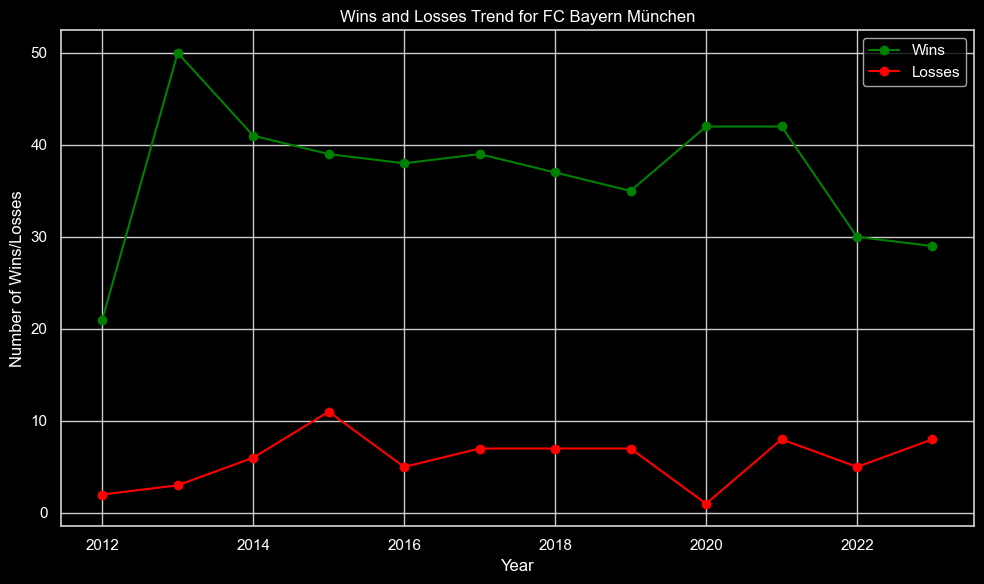

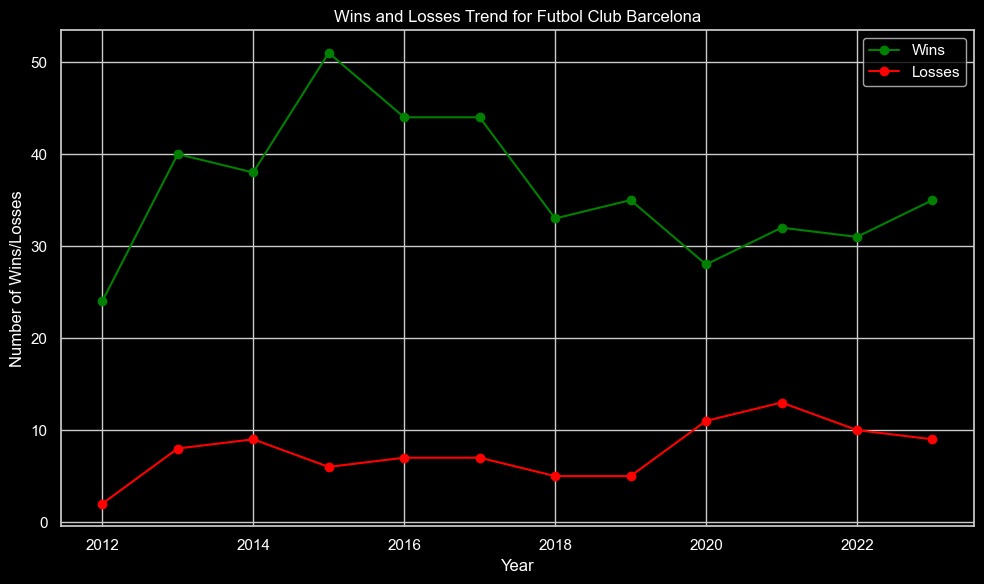

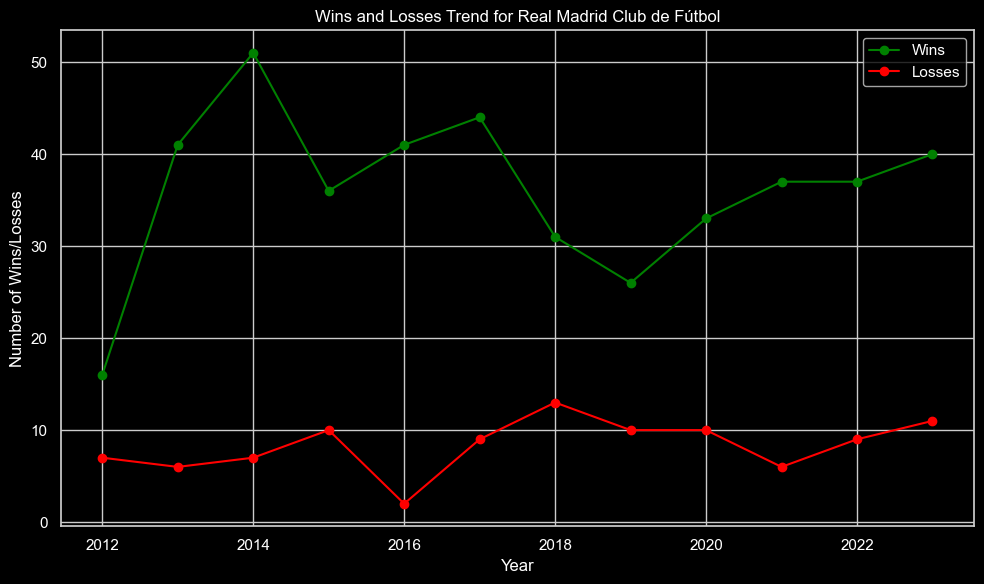

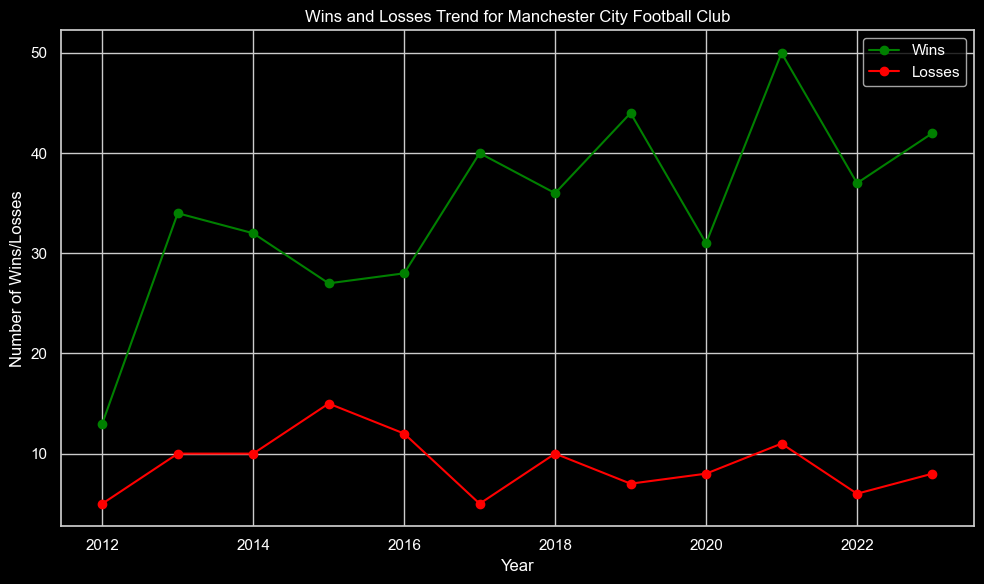

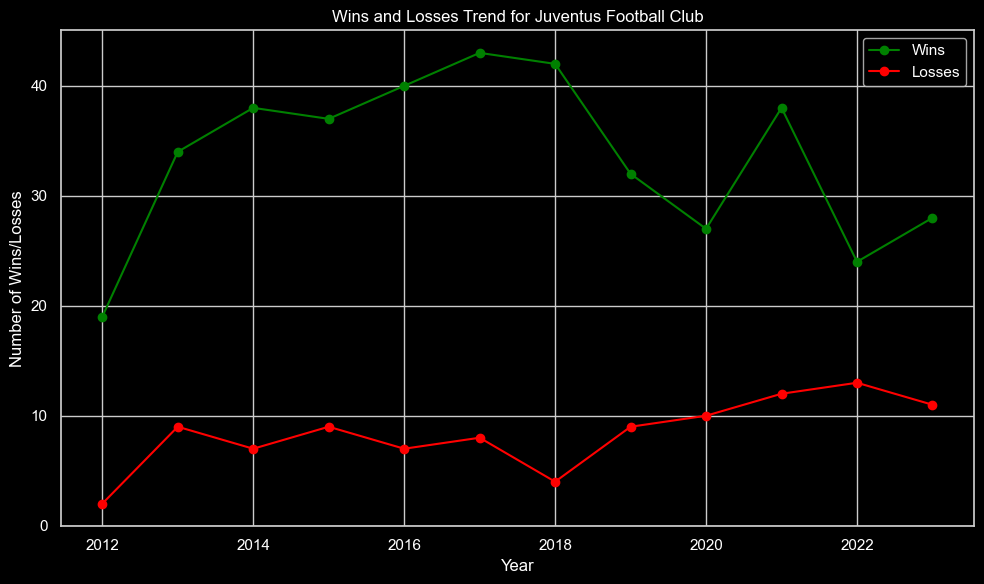

In [16]:
top_clubs = club_performance_sorted.head(5)['name']  # Top 5 club per numero di vittorie

for club in top_clubs:
    club_data = total_performance[total_performance['name'] == club]
    plt.figure(figsize=(10, 6))
    
    plt.plot(club_data['year'], club_data['total_wins'], label='Wins', color='green', marker='o')
    plt.plot(club_data['year'], club_data['total_losses'], label='Losses', color='red', marker='o')
    
    plt.title(f'Wins and Losses Trend for {club}')
    plt.xlabel('Year')
    plt.ylabel('Number of Wins/Losses')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### c. Analisi dei dati relativi ai goal in casa e fuori casa 

differenza tra le prestazioni in casa e fuori casa in dei club con una visione riguardo agli ultimi anni di gioco dei club (2020-2023)

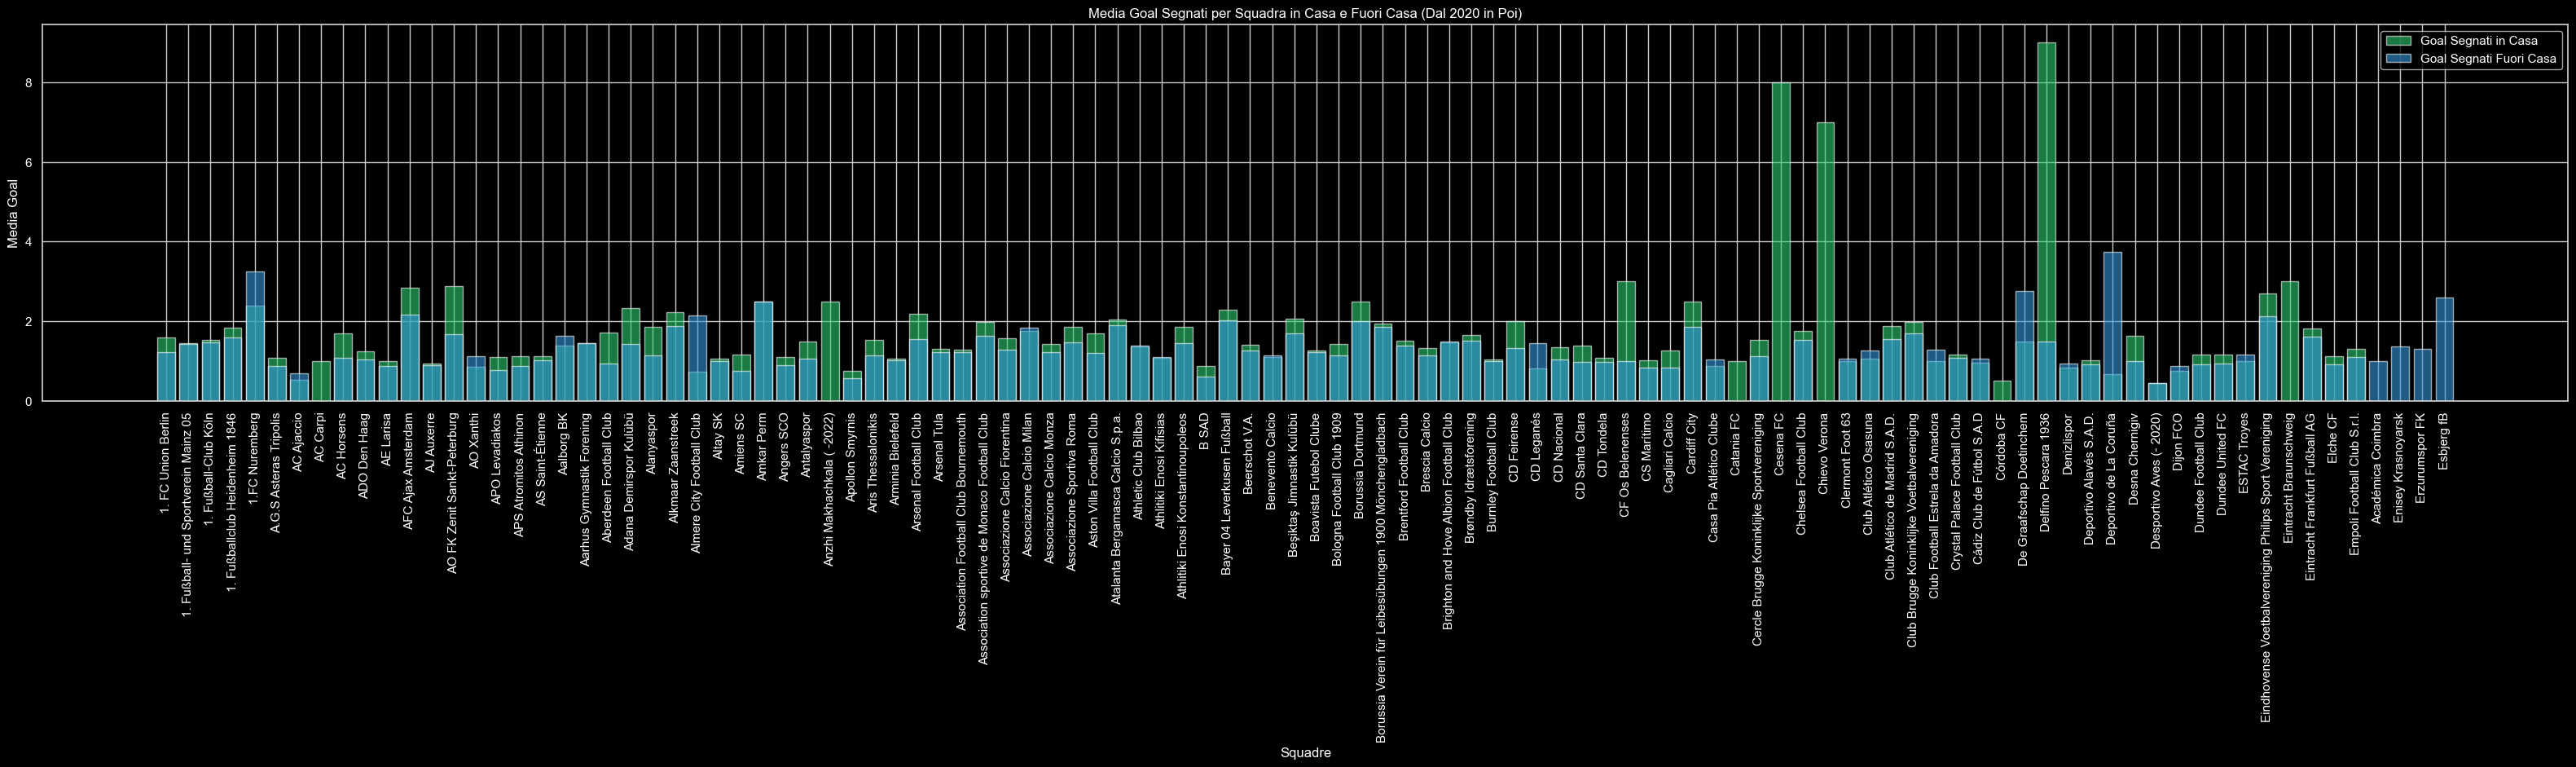

In [17]:
# Converti la colonna 'date' in datetime se non lo è già
dataGames['date'] = pd.to_datetime(dataGames['date'])

# Filtra le partite a partire dall'anno 2020
dataGames_2020_onwards = dataGames[dataGames['date'].dt.year >= 2020]

# Calcola la media dei goal in casa per ogni squadra
home_goals_mean = dataGames_2020_onwards.groupby("home_club_name")["home_club_goals"].mean().head(100)

# Calcola la media dei goal fuori casa per ogni squadra
away_goals_mean = dataGames_2020_onwards.groupby("away_club_name")["away_club_goals"].mean().head(100)

# Crea il grafico a barre
plt.figure(figsize=(40, 6))
plt.bar(home_goals_mean.index, home_goals_mean, label="Goal Segnati in Casa", alpha=0.6)
plt.bar(away_goals_mean.index, away_goals_mean, label="Goal Segnati Fuori Casa", alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel("Squadre")
plt.ylabel("Media Goal")
plt.legend()
plt.title("Media Goal Segnati per Squadra in Casa e Fuori Casa (Dal 2020 in Poi)")
plt.show()

# 2. Analisi delle Formazioni e delle Posizioni dei Giocatori
Utilizzeremo il dataset dataGamesLineups per analizzare come le formazioni e le posizioni dei giocatori influenzano le prestazioni della squadra.


### a. Analisi della Distribuzione delle Posizioni:

Ogni grafico radar rappresenta visivamente la frequenza dei giocatori in ogni posizione per un singolo club.
Le diverse assi del grafico rappresentano le diverse posizioni (ad esempio, attaccante, difensore, centrocampista).
La lunghezza di ogni asse del grafico indica il numero di giocatori in quella specifica posizione nel club.

Confrontando i grafici radar dei diversi club, puoi identificare quali posizioni sono più o meno popolate in ciascun club.
Questo può indicare, ad esempio, una tendenza di un club a investire più in attaccanti piuttosto che in difensori, o viceversa.

Le informazioni derivanti dai grafici possono essere utili per il management dei club per valutare l'equilibrio della squadra, identificare le aree che necessitano di rinforzi e pianificare trasferimenti o strategie di formazione.
Gli allenatori possono utilizzare queste informazioni per comprendere meglio la composizione della squadra e per sviluppare strategie di gioco che sfruttino i punti di forza o mitigino le debolezze.

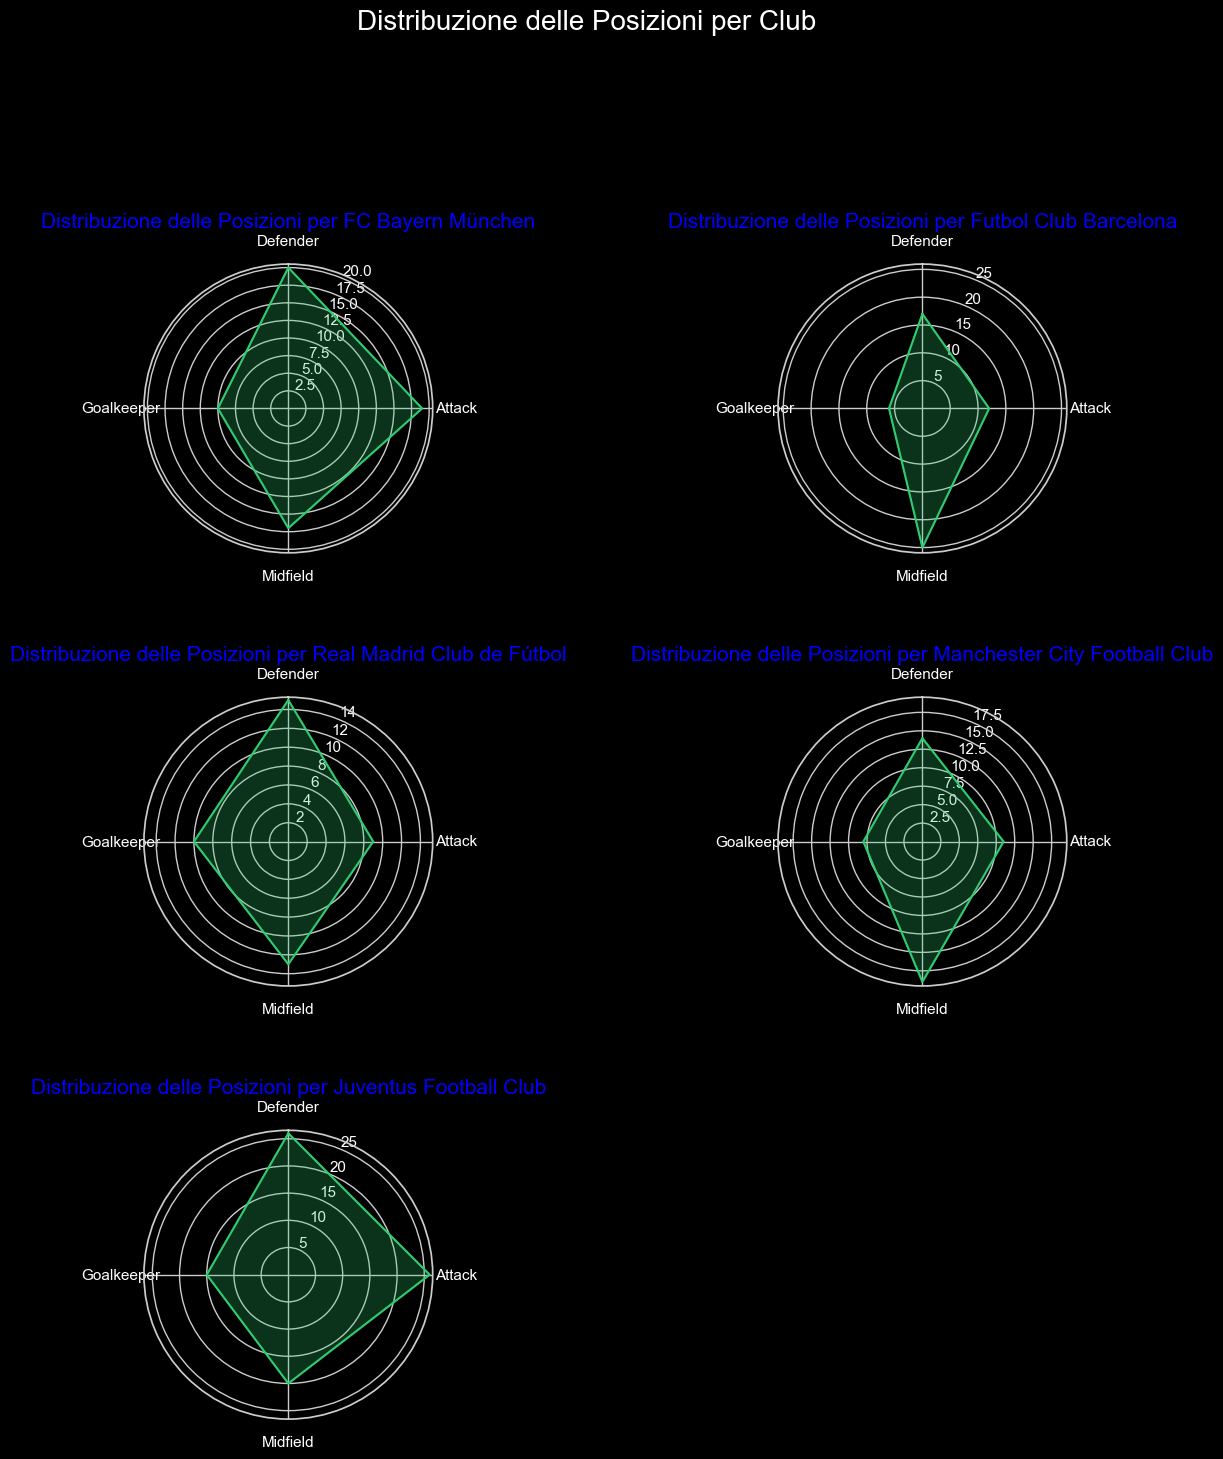

In [18]:

# Assumi di avere una lista dei top 5 club_id
top_club_ids = club_performance_sorted['club_id'].head(5).tolist()

# Filtra i giocatori dei top 5 club
top_club_players = dataPlayers[dataPlayers['current_club_id'].isin(top_club_ids)]

# Preparare i dati
positions = top_club_players['position'].unique()
dataPosition = pd.merge(top_club_players, club_performance_sorted[['club_id', 'name']].head(5), left_on='current_club_id', right_on='club_id', how='left')

# Creare un radar chart per ogni club
num_vars = len(positions)
angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Imposta il layout del grafico
fig, axes = plt.subplots(figsize=(15, 15), nrows=3, ncols=2, subplot_kw=dict(polar=True))
axes = axes.flatten()  # Trasforma la griglia in una lista per un'iterazione più facile

for idx, club_id in enumerate(top_club_ids):
    ax = axes[idx]
    club_name = club_performance_sorted[club_performance_sorted['club_id'] == club_id]['name'].values[0]
    club_data = dataPosition[dataPosition['current_club_id'] == club_id]
    values = [club_data[club_data['position'] == pos].shape[0] for pos in positions]
    values += values[:1]
    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, values, label=f'{club_name}')
    ax.set_title(f'Distribuzione delle Posizioni per {club_name}', size=15, color='blue', y=1.1)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), positions)

# Nasconde gli assi vuoti
for ax in axes[idx+1:]:
    ax.remove()

# Regola lo spazio tra i grafici
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.suptitle('Distribuzione delle Posizioni per Club', size=20, y=1.05)
plt.show()


# 1. Frequenza delle diverse formazioni usate dai club
Iniziamo calcolando la frequenza delle diverse formazioni usate dai club e visualizziamole con un grafico a barre.

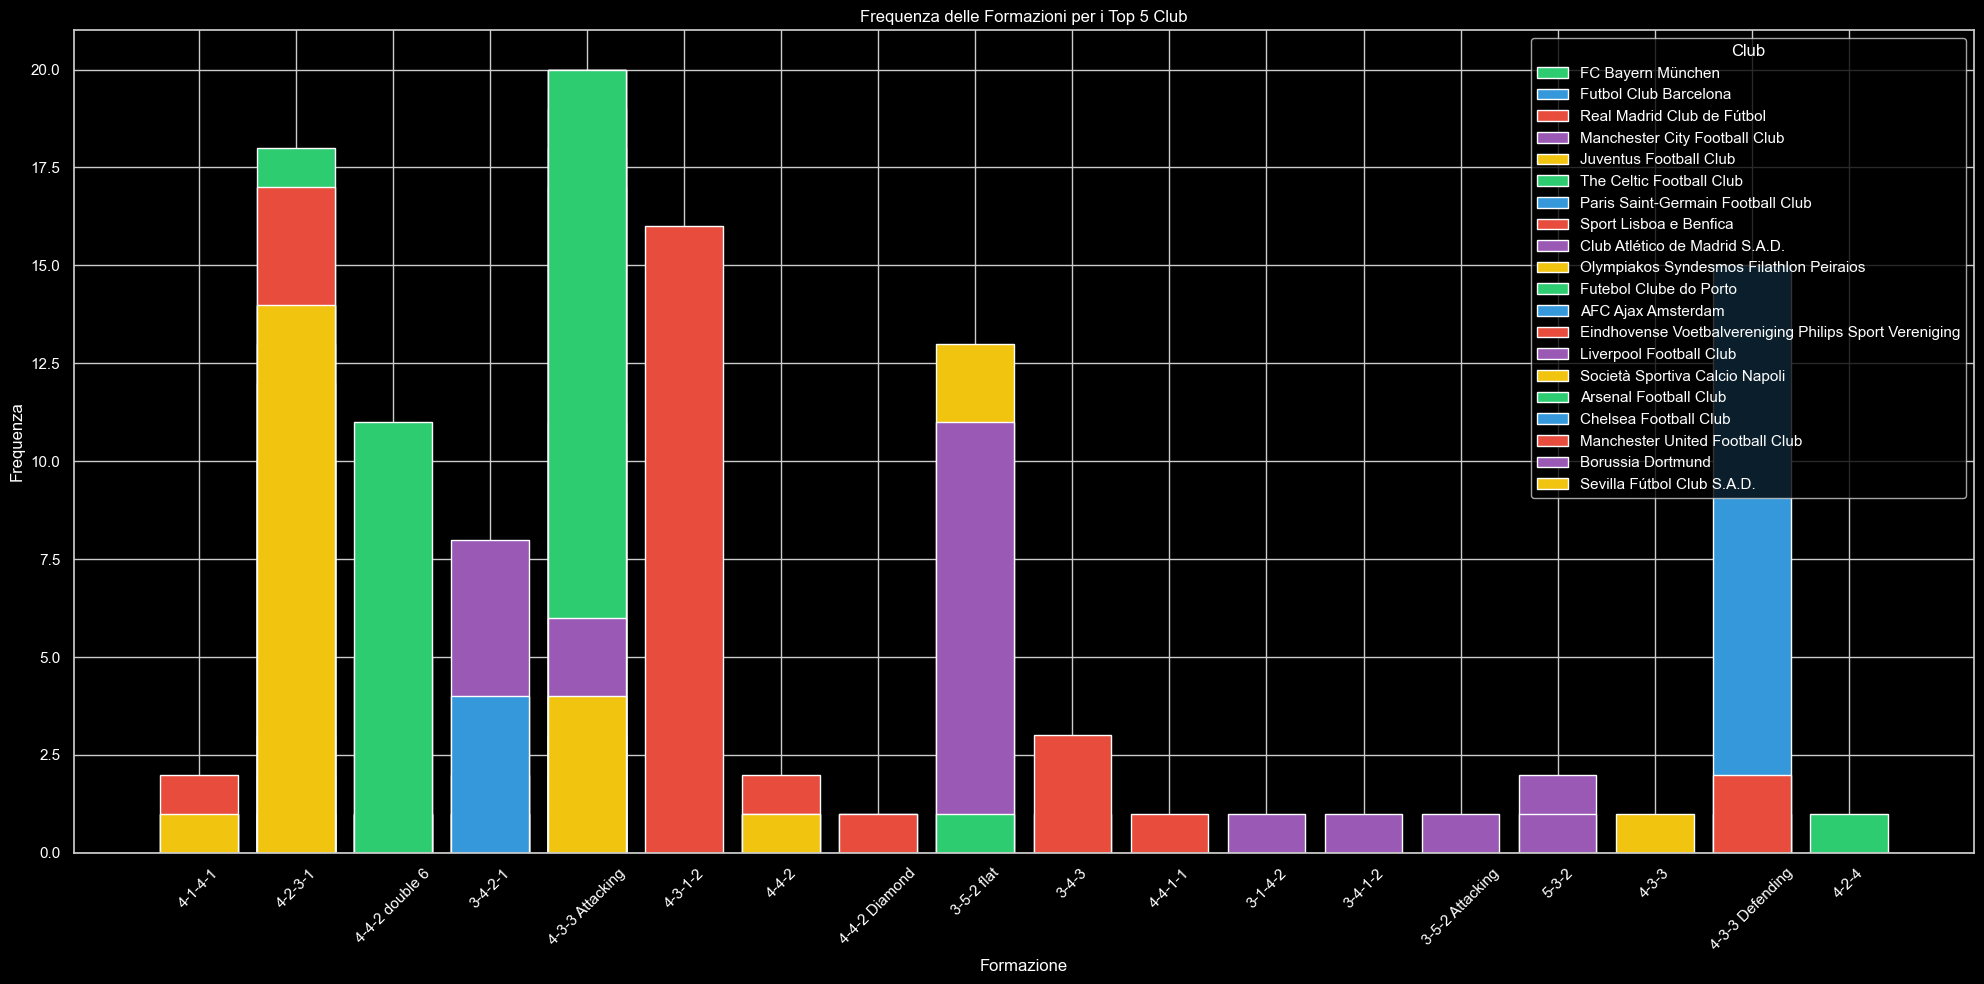

In [19]:


# Estrarre i nomi dei primi 5 club dalla classifica
top_5_clubs = club_performance_sorted.head(20)['name'].tolist()

# Filtrare i giochi che coinvolgono solo i primi 5 club
top_club_games = dataGames[(dataGames['home_club_name'].isin(top_5_clubs)) | (dataGames['away_club_name'].isin(top_5_clubs))]

# Calcolare la frequenza delle formazioni per ogni club
# Assumendo che 'home_club_formation' e 'away_club_formation' siano colonne nel dataset dataGames
formations_freq_home = top_club_games.groupby(['home_club_name', 'home_club_formation']).size().reset_index(name='count')
formations_freq_away = top_club_games.groupby(['away_club_name', 'away_club_formation']).size().reset_index(name='count')

# Combina le frequenze delle formazioni in casa e in trasferta
formations_freq = pd.concat([formations_freq_home.rename(columns={'home_club_name': 'club_name', 'home_club_formation': 'formation'}),
                             formations_freq_away.rename(columns={'away_club_name': 'club_name', 'away_club_formation': 'formation'})])

# Somma le frequenze per ogni club e formazione
formations_freq = formations_freq.groupby(['club_name', 'formation']).agg({'count': 'sum'}).reset_index()

# Grafico a barre delle formazioni
plt.figure(figsize=(20, 10))
for club in top_5_clubs:
    club_data = formations_freq[formations_freq['club_name'] == club]
    plt.bar(club_data['formation'], club_data['count'], label=club)

plt.xlabel('Formazione')
plt.ylabel('Frequenza')
plt.title('Frequenza delle Formazioni per i Top 5 Club')
plt.xticks(rotation=45)
plt.legend(title='Club')
plt.tight_layout()  # Aggiustamento per una visualizzazione ottimale
plt.show()


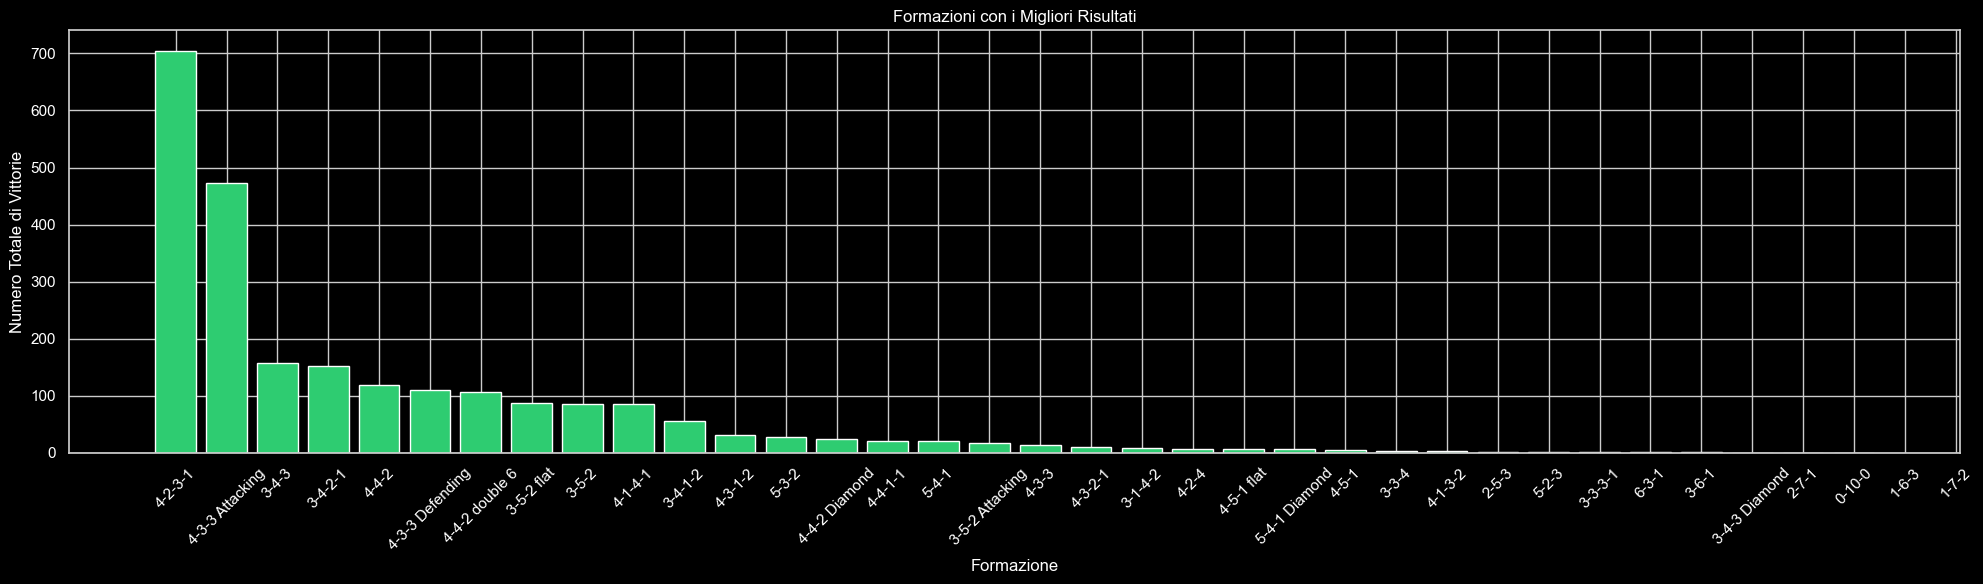

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Estrarre le colonne necessarie
formations_data = dataGames[['home_club_formation', 'away_club_formation', 'home_win', 'away_win', 'draw']]

# Calcolare la somma delle vittorie per ciascuna formazione in casa
home_formations_wins = formations_data.groupby('home_club_formation')['home_win'].sum().reset_index()

# Calcolare la somma delle vittorie per ciascuna formazione in trasferta
away_formations_wins = formations_data.groupby('away_club_formation')['away_win'].sum().reset_index()

# Unire i dati delle vittorie in casa e in trasferta
total_wins = pd.merge(home_formations_wins, away_formations_wins, left_on='home_club_formation', right_on='away_club_formation', how='outer')

# Sommare le vittorie in casa e in trasferta per ciascuna formazione
total_wins['total_wins'] = total_wins['home_win'] + total_wins['away_win']

# Ordinare le formazioni in base al numero totale di vittorie
total_wins = total_wins.sort_values(by='total_wins', ascending=False)

# Convertire le formazioni in stringhe
total_wins['home_club_formation'] = total_wins['home_club_formation'].astype(str)

# Creare il grafico a barre
plt.figure(figsize=(20, 6))
plt.bar(total_wins['home_club_formation'], total_wins['total_wins'])
plt.xlabel('Formazione')
plt.ylabel('Numero Totale di Vittorie')
plt.title('Formazioni con i Migliori Risultati')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Analisi dei  dati riguardanti i migliori club 
voglio analizzare migliori club. i dati che voglio analizzare sono l'età media dei loro giocatori, la distribuzione geografica di questi club, l'età dei loro player, il numero di partite vinte dall'allenatore, quale squadra ha l'allenatore che ha perso meno partite ?

, un grafico per ogni club del valore dei giocatore 
di questi club fare una mappa e segnare le regioni con densità da cui arrivano i giocatori

### a. Analisi andamento dell'età dei player nei top club
generazione di un grafico che permette la visualizzazione dell'andamento dell'età dei player nei club.

/var/folders/9x/57__ff_j1wscnvbjdyy9gsrw0000gp/T/ipykernel_46818/1858658613.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




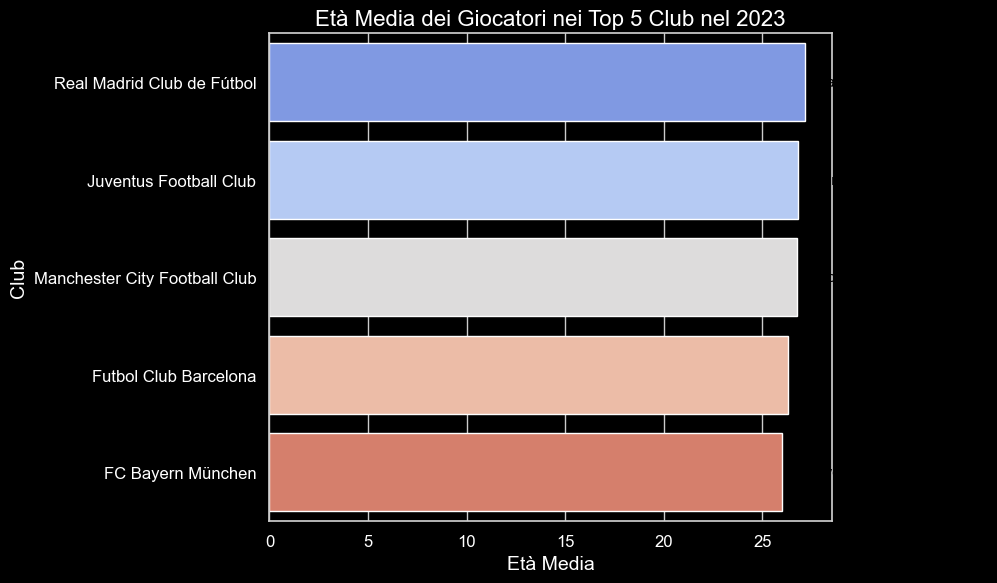

In [21]:

# 1. Pulizia e Preparazione dei Dati
top_5_clubs = club_performance_sorted.head(5)
filtered_players = dataPlayers[dataPlayers['current_club_id'].isin(top_5_clubs['club_id'].tolist())]

filtered_players['date_of_birth'] = pd.to_datetime(filtered_players['date_of_birth'], errors='coerce')

# 2. Calcolo dell'Età
filtered_players['age_in_2023'] = 2023 - filtered_players['date_of_birth'].dt.year
filtered_players = filtered_players.loc[filtered_players['last_season'] == 2023]

# 3. Preparazione dei Dati per il Grafico
age_data = filtered_players.groupby('current_club_id')['age_in_2023'].mean().reset_index()

# Unisci con i nomi dei club
age_data = age_data.merge(top_5_clubs[['club_id', 'name']], left_on='current_club_id', right_on='club_id')

# Ordina i club per età media in modo decrescente
age_data_sorted = age_data.sort_values(by='age_in_2023', ascending=False)

# 4. Creazione del Grafico
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='age_in_2023', y='name', data=age_data_sorted, palette='coolwarm')

# Aggiungi il nome del club sopra ciascuna barra
for index, value in enumerate(age_data_sorted['age_in_2023']):
    plt.text(value, index, f' {age_data_sorted["name"].iloc[index]}', va='center', ha='left', fontsize=10, color='black')

# Titolo e etichette
plt.title('Età Media dei Giocatori nei Top 5 Club nel 2023', fontsize=16)
plt.xlabel('Età Media', fontsize=14)
plt.ylabel('Club', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra il grafico
plt.tight_layout()
plt.show()


### b. analisi della provenienza dei giocatori nelle migliori squadre 

grafo di densità geografica che esprime dove si posizionano i giocatori proveniente dai top Clubs

#### Passo 1: recupero delle cordinate geografiche 

In [26]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd

# Assumi che 'filtered_players' sia il tuo DataFrame e che abbia una colonna 'city_of_birth'

# Inizializza il geolocalizzatore
geolocator = Nominatim(user_agent="geoapiExercises")

# Funzione per ritardare le richieste di geocoding (per evitare il blocco)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Definisci una funzione per ottenere le coordinate
def get_location(row):
    try:
        location = geocode(row['city_of_birth'])
        if location:
            return pd.Series([location.latitude, location.longitude], index=['lat', 'lon'])
    except:
        return pd.Series([None, None], index=['lat', 'lon'])

# Applica la funzione al DataFrame
coordinates = filtered_players.apply(get_location, axis=1)

# Unisci le coordinate con il DataFrame originale
filtered_players = pd.concat([filtered_players, coordinates], axis=1)

#### Passo 2: creazione del grafico 

/var/folders/9x/57__ff_j1wscnvbjdyy9gsrw0000gp/T/ipykernel_46818/1370150426.py:6: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



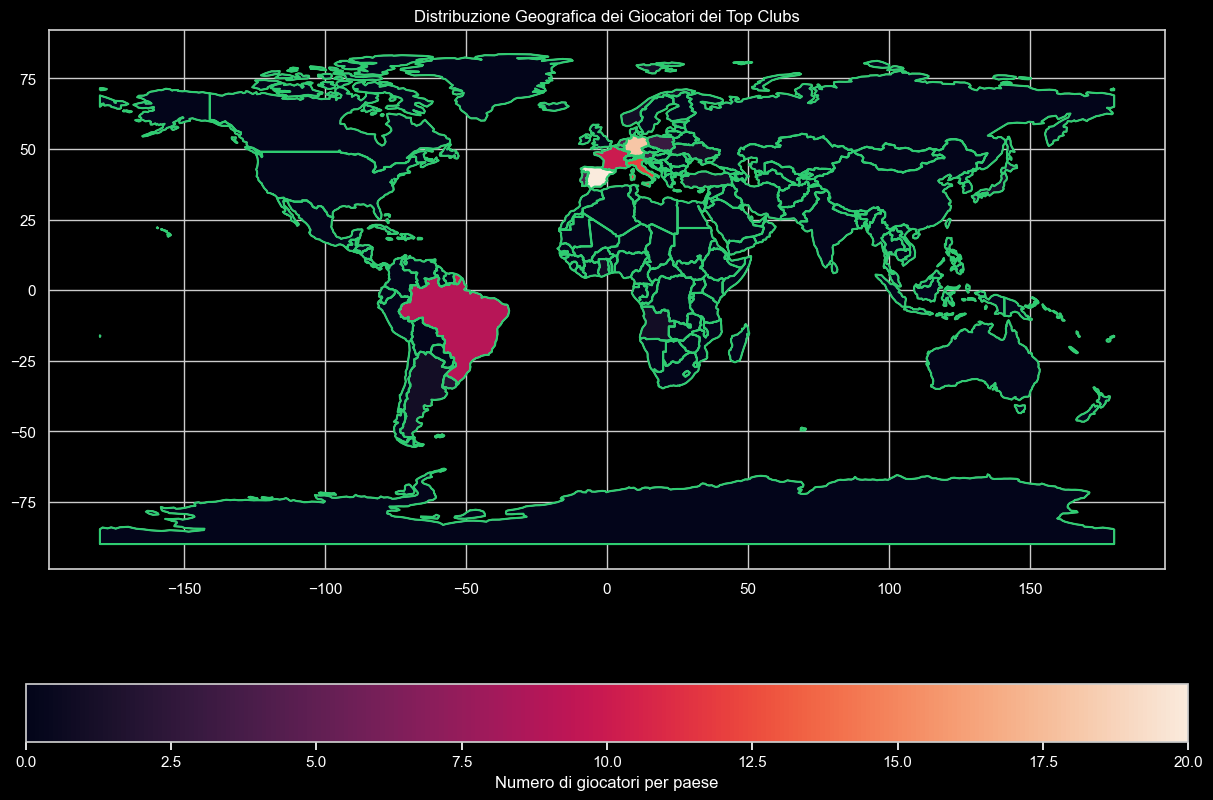

In [27]:
# Contiamo il numero di giocatori per paese di nascita
player_country_counts = filtered_players['country_of_birth'].value_counts().reset_index()
player_country_counts.columns = ['country', 'number_of_players']

# Carichiamo un geodataframe con i confini dei paesi
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Uniamo i dati dei giocatori con il geodataframe
world_players = world.merge(player_country_counts, how="left", left_on="name", right_on="country")

# Impostiamo i valori NaN a 0
world_players['number_of_players'] = world_players['number_of_players'].fillna(0)

# Creiamo la mappa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_players.boundary.plot(ax=ax)
world_players.plot(column='number_of_players', ax=ax, legend=True,
                 legend_kwds={'label': "Numero di giocatori per paese",
                              'orientation': "horizontal"})
plt.title('Distribuzione Geografica dei Giocatori dei Top Clubs')
plt.show()


### Analisi delle prestazioni dei manager delle migliori squadre negli ultimi anni 



filtraggio dati delle prestazioni

In [36]:
import pandas as pd

# Converti dataGames in un DataFrame
# dataGames = ...

# Filtra per l'anno 2023
games_2023 = dataGames[dataGames['year'] == 2023]

# Funzione per calcolare le prestazioni di ciascun manager
def calculate_manager_performance(df):
    # Inizializza una lista vuota per raccogliere i dati delle prestazioni
    performance_data = []
    
    for manager in df['home_club_manager_name'].unique():
        manager_games = df[(df['home_club_manager_name'] == manager) | (df['away_club_manager_name'] == manager)]
        wins = manager_games[((manager_games['home_club_manager_name'] == manager) & (manager_games['home_win'])) | 
                             ((manager_games['away_club_manager_name'] == manager) & (manager_games['away_win']))].shape[0]
        draws = manager_games[manager_games['draw']].shape[0]
        losses = manager_games.shape[0] - wins - draws
        goals_for = manager_games[manager_games['home_club_manager_name'] == manager]['home_club_goals'].sum() + \
                    manager_games[manager_games['away_club_manager_name'] == manager]['away_club_goals'].sum()
        goals_against = manager_games[manager_games['home_club_manager_name'] == manager]['away_club_goals'].sum() + \
                        manager_games[manager_games['away_club_manager_name'] == manager]['home_club_goals'].sum()

        # Aggiungi i dati delle prestazioni alla lista
        performance_data.append({
            'Manager': manager, 'Wins': wins, 'Draws': draws, 'Losses': losses, 
            'Goals For': goals_for, 'Goals Against': goals_against
        })
    
    # Crea un DataFrame dai dati raccolti
    performance = pd.DataFrame(performance_data)
    return performance

# Calcola le prestazioni dei manager
manager_performance = calculate_manager_performance(games_2023)

creazione dei grafiuci 

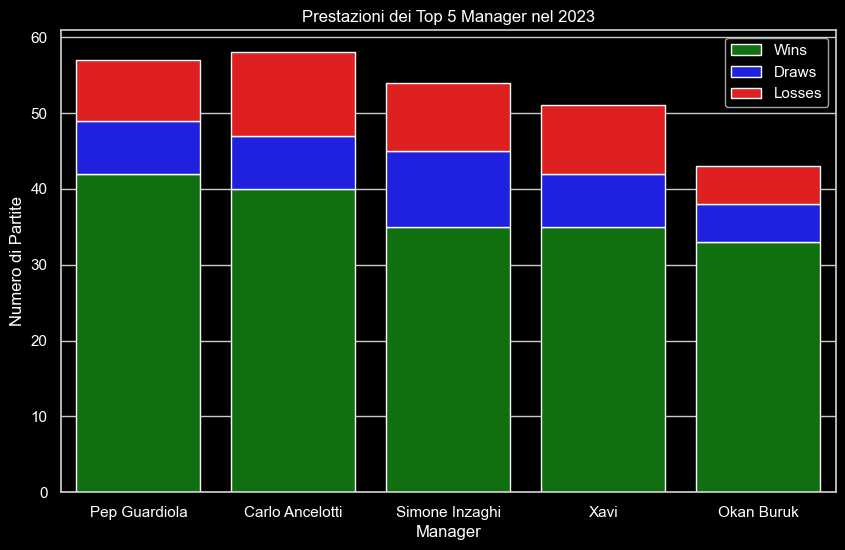

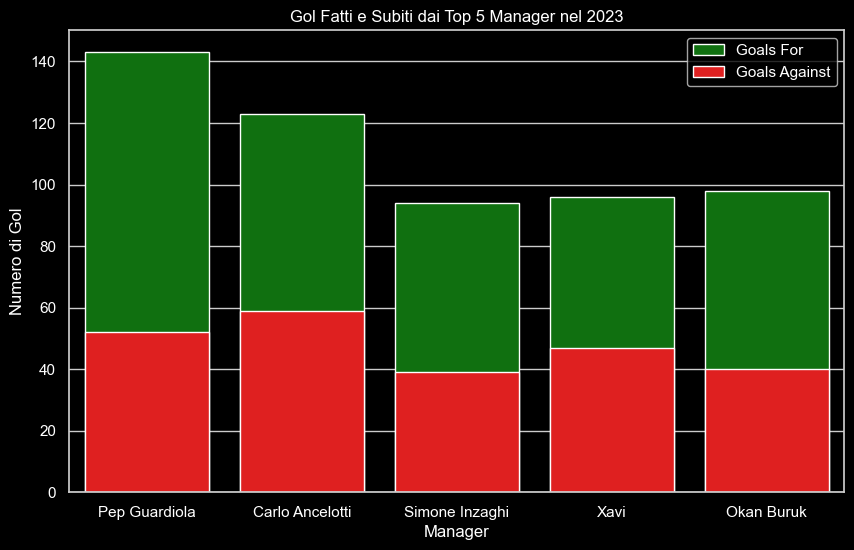

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selezioniamo i top 5 manager per numero di vittorie
top_managers = manager_performance.sort_values(by='Wins', ascending=False).head(5)

# Grafico delle vittorie, pareggi e sconfitte
plt.figure(figsize=(10, 6))
sns.barplot(x='Manager', y='Wins', data=top_managers, label="Wins", color='green')
sns.barplot(x='Manager', y='Draws', data=top_managers, label="Draws", color='blue', bottom=top_managers['Wins'])
sns.barplot(x='Manager', y='Losses', data=top_managers, label="Losses", color='red', 
            bottom=top_managers['Wins'] + top_managers['Draws'])
plt.title('Prestazioni dei Top 5 Manager nel 2023')
plt.ylabel('Numero di Partite')
plt.xlabel('Manager')
plt.legend()
plt.show()

# Grafico dei gol fatti e subiti
plt.figure(figsize=(10, 6))
sns.barplot(x='Manager', y='Goals For', data=top_managers, label="Goals For", color='green')
sns.barplot(x='Manager', y='Goals Against', data=top_managers, label="Goals Against", color='red')
plt.title('Gol Fatti e Subiti dai Top 5 Manager nel 2023')
plt.ylabel('Numero di Gol')
plt.xlabel('Manager')
plt.legend()
plt.show()
